# MORPHOLOGY

In [20]:
from cv2 import imread, cvtColor, COLOR_BGR2RGB, getStructuringElement, MORPH_ELLIPSE, erode, dilate, countNonZero, \
    subtract, connectedComponents, COLOR_BGR2GRAY
from matplotlib.pyplot import figure, subplot, title, axis, imshow, show, plot
from numpy import uint8, zeros, double

In [21]:
figure_size = (18,7)
def show_images(name, imgs, desc, col=None):
    figure(figsize=figure_size)
    n = len(imgs)
    for k in range(0, n):
        img = imgs[k].astype(uint8)
        tit = name + " " + desc[k]
        if col is not None:
            c = col[k]
            subplot(1, n, k + 1), title(tit), axis('off'), imshow(img, cmap=c)
        else:
            subplot(1, n, k + 1), title(tit), axis('off'), imshow(img)
    show()
def rgb(img):
    return cvtColor(img, COLOR_BGR2RGB)
def gray(img):
    return cvtColor(img, COLOR_BGR2GRAY)
def binarize(img):
    img = img.astype(int)
    m,n,_ = img.shape
    gray = zeros((m,n), int)
    for i in range(0,m):
        for k in range(0,n):
            gray[i,k] = 1 if img[i,k,0] > 180 else 0
    return gray

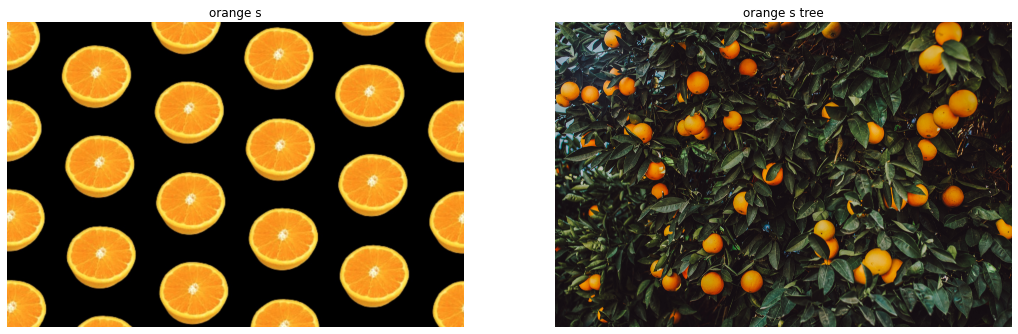

In [22]:
image1 = rgb(imread("images/oranges.jpg"))
image2 = rgb(imread("images/orangetree.jpg"))
show_images("orange",[image1,image2],["s", "s tree"])

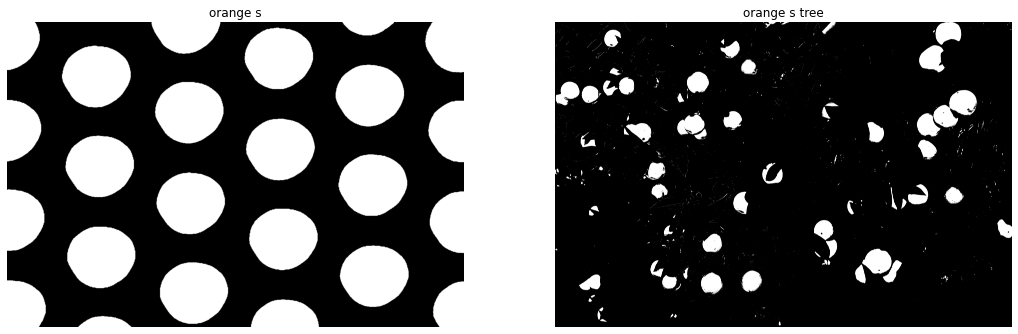

In [23]:
# empirical threshold
orange1 = binarize(image1)
orange2 = binarize(image2)
show_images("orange",[orange1,orange2],["s", "s tree"],['gray','gray'])

In [24]:
def morphological_open(img, k, dtype=uint8, debug=False):
    img = img.astype(dtype)
    kernel = getStructuringElement(MORPH_ELLIPSE, (k,k))
    eroded = erode(img,kernel)
    dilated = dilate(eroded, kernel)
    pix_sum = countNonZero(dilated)
    diff = subtract(img,dilated)

    if debug:
        subplot(1,3,1), axis('off'), title('orig'), imshow(img,'gray')
        subplot(1,3,2), axis('off'), title('eroded'), imshow(eroded,'gray')
        subplot(1,3,3), axis('off'), title('dilated'), imshow(dilated,'gray')
        show()

    return eroded, dilated, pix_sum, diff

def morphological_close(img, k, dtype=uint8, debug=False):
    img = img.astype(dtype)
    kernel = getStructuringElement(MORPH_ELLIPSE, (k,k))
    dilated = dilate(img, kernel)
    eroded = erode(dilated,kernel)
    pix_sum = countNonZero(dilated)
    diff = subtract(img,dilated)

    if debug:
        subplot(1,3,1), axis('off'), title('orig'), imshow(img,'gray')
        subplot(1,3,2), axis('off'), title('eroded'), imshow(eroded,'gray')
        subplot(1,3,3), axis('off'), title('dilated'), imshow(dilated,'gray')
        show()

    return eroded, dilated, pix_sum, diff

In [25]:
# here i created this basic procedure to evaluate the sizes of the needed
# se components for each image, to then use that for the counting procedure
def test_se_sizes(bw_img,r,dtype=uint8,debug=False):
    sums = []; diffs = []; sizes = []
    # given a range r, which determines the sizes to test the SE with
    # start from the lowest size, and increase it gradually
    for i in range(0,len(r)):
        sizes.append(r[i])                                   # testing SE size r[i]
        _,_,s,_ = morphological_open(bw_img,r[i],dtype,debug)      # apply open morphological operation to better separate distinct objects
        sums.append(s)                                       # collect surface area of the opened image

    for i in range(0,len(sums)-1):                            # sum adjacent elements between areas collected
        diffs.append(abs(sums[i]-sums[i+1]))

    title("difference open"), plot(sizes[:-1], diffs), show() # show plot of differences


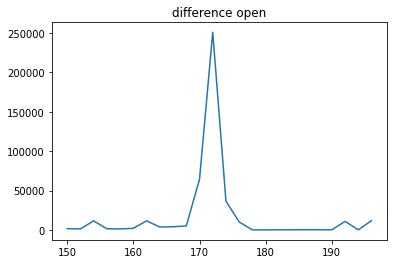

In [26]:
test_se_sizes(orange1,r = range(150,200,2))

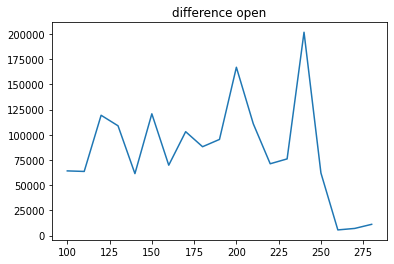

In [27]:
test_se_sizes(orange2,r = range(100,300,10))

As we can see from the plots, the peaks in the function given by the procedure above described will
represent the point in which changing the size of the SE component used for the analysis, leads to a drastic
reduction in the number of object restored after applying erosion, and then dilation.

This is indicating that the SE size being used, exceeds the size of the objects we are trying to identify,
and therefore, these gets depleted by erosion, without any chance for dilation to recover them, e.g.

Assume that starting with SE size $ S = X1 $ , we can still see all the objects in the image after open morphological operation.
Then let $ X2 = X + k $  where $ k > 0 $,
Assume that using $ S = X2 $ we can't see anymore the objects in the image after open morphological operation,
Then it means that the objects we are looking for have size $ X1 < Sx < X2 $

Hence, by subtracting the surface area generated by the opened image and making a ratio between the different
sizes tested, will give us the distribution of the object sizes in the image, at which we can then look
to see where these differences where higher.

Of course, due to not all oranges having the same size in both images, the spikes in the graph
will be multiple ones, and they will be higher when the more of the objects will be filtered at that size.
This factor is much more highlighted in the second picture analysis, due to the oranges hidden by the leaves

In [28]:
def count_objects_1():
    # found out minimum size of the oranges is approx 155
    # but the complete elliptical shaped ones have diam 175,
    # therefore the number of counted objects may vary depending from
    # the chosen SE size
    min_size_1 = getStructuringElement(MORPH_ELLIPSE, (155,155))                # this gives pretty much all oranges
    # standard_size_1 = getStructuringElement(MORPH_ELLIPSE, (175,175))         # this gives pretty much all fully drawn oranges
    r = count_objects(orange1, min_size_1)
    print('Image 1 : Found %f oranges' %r)

    return

In [29]:
def count_objects(img, se):
    img = img.astype(uint8)
    d = erode(img,se)                   # apply erosion to remove small components
    e = dilate(d, se)                   # apply dilatation to enhance the objects pixels
    ret,_ = connectedComponents(e)      # label clustered pixel and count objects
    count = ret-1                       # background is a connected component so take count-1

    # debug
    # subplot(1,3,1), axis('off'), title('image'), imshow(img,'gray')
    # subplot(1,3,2), axis('off'), title('dilated'), imshow(d,'gray')
    # subplot(1,3,3), axis('off'), title('eroded'), imshow(e,'gray')
    # show()
    return count


In [30]:
def count_objects_2():
    # as described above, due to the hidden oranges there are some minor peaks and some major ones
    minor = [120,150,175]
    major = [200,240]
    min_sum = 0; maj_sum = 0
    for mi in minor:
        se = getStructuringElement(MORPH_ELLIPSE, (mi,mi))
        min_sum += count_objects(orange2,se)

    for ma in major:
        se = getStructuringElement(MORPH_ELLIPSE, (ma,ma))
        maj_sum += count_objects(orange2,se)

    min_avg = min_sum / len(minor)
    maj_avg = maj_sum / len(major)

    print("Counted %f small oranges,  %f big oranges" %(min_avg, maj_avg))
    return

In [31]:
count_objects_1()
count_objects_2()

Image 1 : Found 22.000000 oranges
Counted 27.666667 small oranges,  14.000000 big oranges


# Granulometry

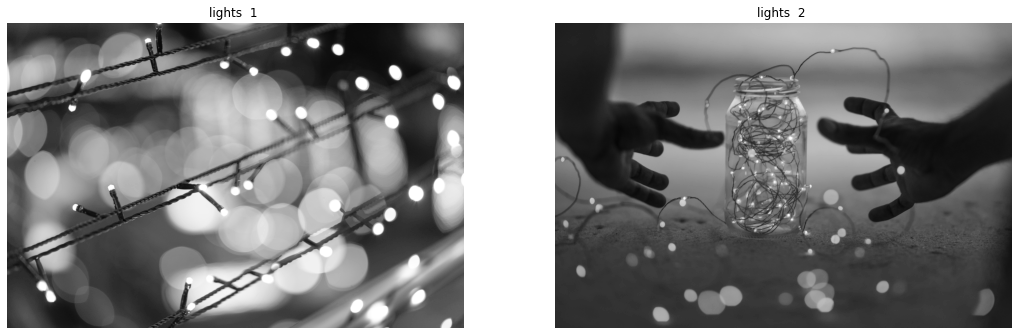

In [32]:
light1 = gray(imread('images/lights.jpg'))
light2 = gray(imread('images/jar.jpg'))
show_images("lights",[light1,light2],[" 1 ", " 2 "],['gray','gray'])

In [ ]:
test_se_sizes(light1,r = range(10,200,20),dtype=double)

In [ ]:
test_se_sizes(light2,r = range(10,200,20),dtype=double)
